,Description,Value
0,session_id,123
1,Target,temperature
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(725, 53)"
5,Transformed data shape,"(725, 53)"
6,Transformed train set shape,"(718, 53)"
7,Transformed test set shape,"(7, 53)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-24,0.0539,0.0350,0.0510,0.0534,0.0017,0.0017,-226044535247206131804667904.0000
1,2024-12-31,0.0678,0.0438,0.0635,0.0665,0.0021,0.0021,-350287990396898236925214720.0000
2,2025-01-07,0.0568,0.0366,0.0527,0.0553,0.0018,0.0018,-241895031269660951241031680.0000
3,2025-01-14,0.0540,0.0347,0.0496,0.0520,0.0017,0.0017,-214473257762791002283704320.0000
4,2025-01-21,0.9818,0.7108,0.8921,1.0620,0.0323,0.0323,-0.7343
Mean,NaT,0.2429,0.1722,0.2218,0.2578,0.0079,0.0079,-206540162935311278194819072.0000
SD,NaT,0.3695,0.2693,0.3352,0.4021,0.0122,0.0122,114031222086789113623609344.0000


MAE: 0.89
MAPE: 3.32%
R2: -0.21
Accuracy: 96.68%


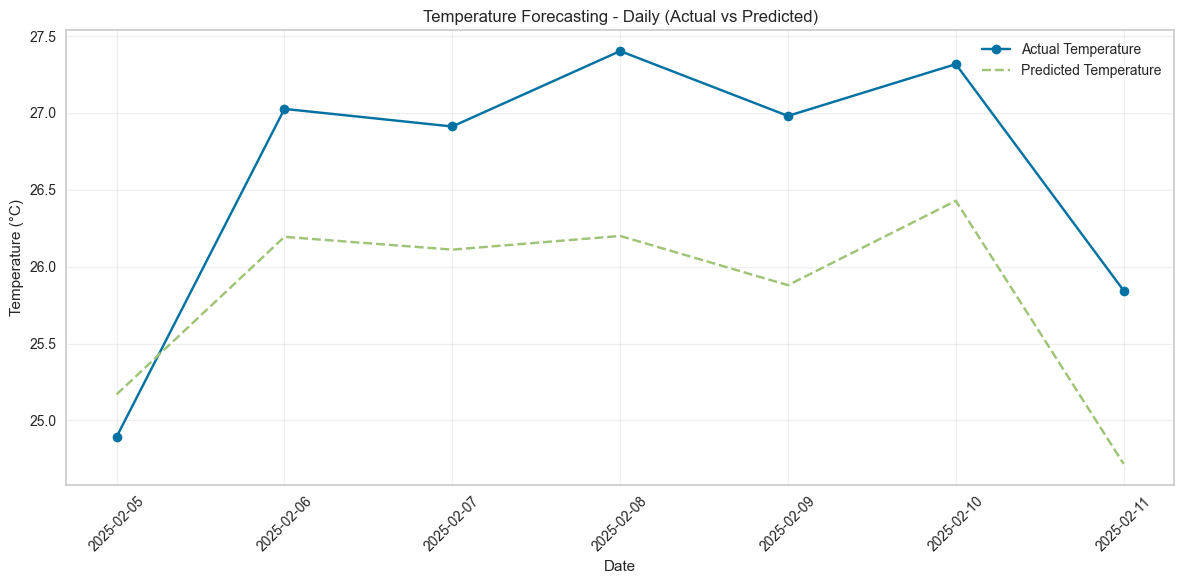

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# Load data
df = pd.read_csv("CSV\export-pkk_cha_uat_school-1h.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.set_index("timestamp", inplace=True)

# Keep only the last 2 years of data
two_years_ago = df.index.max() - pd.DateOffset(years=2)
df = df[df.index >= two_years_ago]

# Drop unnecessary columns
df.drop(columns=["timezone", "Unnamed: 0", "pm_2_5_sp", "location", "pm_10"], inplace=True, errors="ignore")

# Remove outliers using IQR for temperature
Q1t = df["temperature"].quantile(0.25)
Q3t = df["temperature"].quantile(0.75)
IQRt = Q3t - Q1t
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)]

# Remove outliers for other features that will be used
Q1h = df["humidity"].quantile(0.25)
Q3h = df["humidity"].quantile(0.75)
IQRh = Q3h - Q1h
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)]

Q1p = df["pm_2_5"].quantile(0.25)
Q3p = df["pm_2_5"].quantile(0.75)
IQRp = Q3p - Q1p
df = df[(df["pm_2_5"] >= Q1p - 1.5 * IQRp) & (df["pm_2_5"] <= Q3p + 1.5 * IQRp)]

# Interpolate missing values
df.interpolate(method="linear", inplace=True)

# Resample to daily frequency
df = df.resample("D").mean()

# Add Fourier terms for weekly seasonality (very important for temperature)
fourier = Fourier(period=7, order=3)  # Weekly seasonality with higher order for temperature
fourier_features = fourier.in_sample(df.index)
df = pd.concat([df, fourier_features], axis=1)
df.dropna(inplace=True)

# Add annual seasonality terms (critical for temperature forecasting)
fourier_annual = Fourier(period=365, order=4)  # Annual seasonality
annual_features = fourier_annual.in_sample(df.index)
annual_features.columns = [f'annual_{col}' for col in annual_features.columns]
df = pd.concat([df, annual_features], axis=1)

# Add lag features - more important for temperature forecasting
for lag in [1, 2, 3, 7, 14, 21, 30]:  # More lags for temperature patterns
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)

# Add rolling statistics (mean, std, min, max)
for window in [3, 7, 14, 30]:  # Windows more relevant for temperature
    # Temperature rolling stats
    df[f"temperature_rollmean{window}"] = df["temperature"].shift(1).rolling(window=window, min_periods=1).mean()
    df[f"temperature_rollstd{window}"] = df["temperature"].shift(1).rolling(window=window, min_periods=1).std()
    df[f"temperature_rollmin{window}"] = df["temperature"].shift(1).rolling(window=window, min_periods=1).min()
    df[f"temperature_rollmax{window}"] = df["temperature"].shift(1).rolling(window=window, min_periods=1).max()
    
    # Humidity rolling stats (relevant for temperature)
    df[f"humidity_rollmean{window}"] = df["humidity"].shift(1).rolling(window=window, min_periods=1).mean()

# Add day of year and month features (important for temperature seasonality)
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek

# Remove the original pm_2_5 column as we're predicting temperature
df = df.drop(columns=["pm_2_5"])

# Fill any remaining missing values
df = df.asfreq("D").fillna(method="bfill")

# Ensure the same features are used in both train and test
# DO NOT drop the target column from the training data
train = df.iloc[:-7]
test = df.iloc[-7:]

# Drop the target column ONLY from the test data
test_features = test.drop(columns=["temperature"])

# Setup the experiment
experiment = setup(
    data=train,  # Training data WITH the target column
    target="temperature",  # Target is now temperature
    session_id=123,
    use_gpu=True,
    fh=7,  # Forecast horizon = 7 days
    fold=5,  # Increased folds for better validation
    seasonal_period=["D"],  # Multiple seasonal periods for temperature
    verbose=True,
)

# Convert test index to period format
test_features.index = test_features.index.to_period("D")

# Create and tune models
arima_model = create_model("arima")
final_model = finalize_model(arima_model)

# Make predictions
predictions = predict_model(final_model, X=test_features)  # Use test_features (without target column)

# Evaluate performance
mae = mean_absolute_error(test["temperature"], predictions)
mape = mean_absolute_percentage_error(test["temperature"], predictions) * 100
r2 = r2_score(test["temperature"], predictions)
accuracy = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(
    test.index, test["temperature"], label="Actual Temperature", marker="o"  # Use test.index directly
)
plt.plot(
    test.index,  # Use test.index directly
    predictions,
    label="Predicted Temperature",
    linestyle="--",
    marker="x",
)
plt.title("Temperature Forecasting - Daily (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance analysis (if your model supports it)
if hasattr(final_model, 'get_feature_importance'):
    importance = final_model.get_feature_importance()
    plt.figure(figsize=(10, 8))
    importance.sort_values().plot(kind='barh')
    plt.title('Feature Importance for Temperature Prediction')
    plt.tight_layout()
    plt.show()

In [2]:
save_model(final_model, "Temp_cha_uat_school")

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(seasonal_order=(0,
                                                                                                                                                       1,
                                                                                                                                                       0,
                                                                                                                                                       7)))]))]))]))]),
 'Temp_c

In [ ]:
test_features.to_csv("Temp_cha_uat_school_predic.csv")

: 